Vineet Gandham
734004258


In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, random_split
import torchvision.transforms as transforms
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
from PIL import Image

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
class CustomDataset(Dataset):
    def __init__(self, image_data, audio_data, labels,transform):
        self.image_data = np.load(image_data)
        self.audio_data = np.load(audio_data)
        df = pd.read_csv(labels)
        self.labels = df['label'].values
        self.transform = transform

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        image = self.image_data[idx]
        image = Image.fromarray(image)
        audio = torch.from_numpy(self.audio_data[idx]).float()
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        image_reshaped = image.view(1, 28, 28)
        audio_reshaped = audio[:-7].view(10, 50)
        return image_reshaped, audio_reshaped, label

In [43]:
transform2 = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1,), (0.3,)),
    transforms.RandomHorizontalFlip(p=0.5),
    # transforms.RandomRotation(degrees=25),
])

In [44]:
dataset_train_transformed = CustomDataset(image_data='/content/drive/My Drive/HealthCareFinal/Scratch/x_train_wr.npy',
                                      audio_data='/content/drive/My Drive/HealthCareFinal/Scratch/x_train_sp.npy',
                                      labels='/content/drive/My Drive/HealthCareFinal/Scratch/y_train.csv',transform=transform2)

In [40]:
# Calculate label counts using np.bincount
label_counts = np.bincount(dataset_train_transformed.labels)
print(label_counts)

unique_labels = np.unique(dataset_train_transformed.labels)
for label in unique_labels:
    count = np.sum(dataset_train_transformed.labels == label)
    print(f"Label {label}: {count} occurrences")

[5923 6742 5958 6131 5842 5421 5918 6265 5851 5949]
Label 0: 5923 occurrences
Label 1: 6742 occurrences
Label 2: 5958 occurrences
Label 3: 6131 occurrences
Label 4: 5842 occurrences
Label 5: 5421 occurrences
Label 6: 5918 occurrences
Label 7: 6265 occurrences
Label 8: 5851 occurrences
Label 9: 5949 occurrences


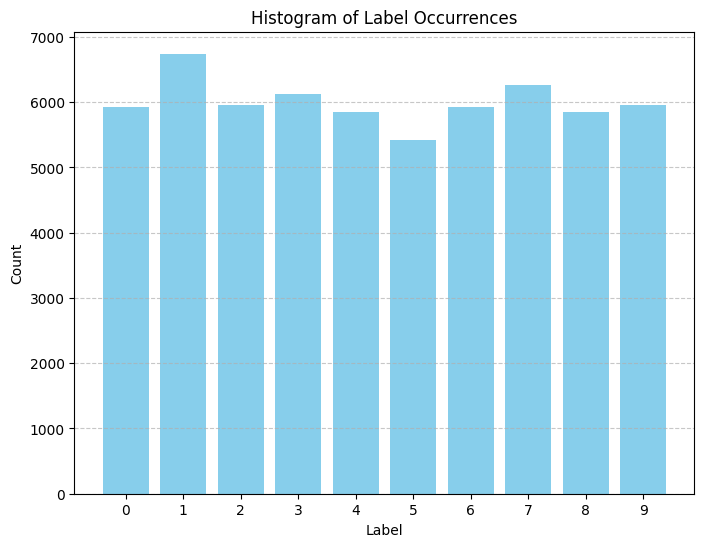

In [41]:
# Plotting the histogram
plt.figure(figsize=(8, 6))
plt.bar(unique_labels, label_counts, color='skyblue')
plt.xlabel('Label')
plt.ylabel('Count')
plt.title('Histogram of Label Occurrences')
plt.xticks(unique_labels)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [50]:
dataset_train_transformed[0][1].shape

torch.Size([10, 50])

In [6]:
from torch import nn
import torch.nn.functional as F

In [59]:
# Define the image encoder using a CNN
class ImageEncoder(nn.Module):
    def __init__(self):
        super(ImageEncoder, self).__init__()
        self.cnn = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(16),  # Add batch normalization after the first convolutional layer
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout2d(p=0.25),
            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),  # Add batch normalization after the second convolutional layer
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout2d(p=0.25)
        )
        self.fc = nn.Sequential(
            nn.Linear(32 * 7 * 7, 100),
            nn.BatchNorm1d(100),  # Add batch normalization after the first linear layer
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(100, 72),
            nn.BatchNorm1d(72),  # Add batch normalization after the second linear layer
            nn.ReLU(),
            nn.Dropout(p=0.5)
        )


    def forward(self, x):
        features = self.cnn(x)
        features = features.view(features.size(0), -1)
        features = self.fc(features)
        return features

In [55]:
class AudioEncoder(nn.Module):
    def __init__(self, input_size=50, hidden_size=36):
        super(AudioEncoder, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers=2, batch_first=True,dropout=0.3)

    def forward(self, x):
        _, (hidden, _) = self.lstm(x)
        hidden = torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim=1)
        features = hidden.squeeze(0)
        return features

In [65]:
class MultimodalClassifier(nn.Module):
    def __init__(self, image_encoder, audio_encoder):
        super(MultimodalClassifier, self).__init__()
        self.image_encoder = image_encoder
        self.audio_encoder = audio_encoder
        self.fc = nn.Linear(72, 60)
        self.fc2 = nn.Linear(60, 46)
        self.fc3 = nn.Linear(46, 10)

    def forward(self, image_input, audio_input):
        image_features = self.image_encoder(image_input)
        audio_features = self.audio_encoder(audio_input)
        combined_features = image_features + audio_features
        # combined_features = torch.cat((image_features, audio_features), dim=1)
        output1 = F.relu(self.fc(combined_features))
        output2 = F.dropout(self.fc2(output1),p=0.2)
        output3 = self.fc3(output2)
        return output3

In [99]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

image_encoder = ImageEncoder().to(device)
audio_encoder = AudioEncoder().to(device)
model = MultimodalClassifier(image_encoder, audio_encoder).to(device)

optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

validation_size = 0.2

# Determine sizes for training and validation
num_samples = len(dataset_train_transformed)
num_val_samples = int(validation_size * num_samples)
num_train_samples = num_samples - num_val_samples

# Split dataset into training and validation
train_dataset, val_dataset = random_split(dataset_train_transformed, [num_train_samples, num_val_samples])

# Train the model
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=True)

In [10]:
print(len(train_dataset))

48000


In [49]:
from sklearn.metrics import accuracy_score, f1_score
# Define some reusable functions to train and evaluate function
def evaluate_model(model, val_loader):
    model.eval()
    correct = 0
    total = 0
    all_labels = []
    all_predicted = []
    with torch.no_grad():
        for images, audios, labels in val_loader:
            images, audios, labels = images.to(device), audios.to(device), labels.to(device)
            outputs = model(images, audios)
            _, predicted = torch.max(outputs, 1)
            # total += labels.size(0)
            # correct += (predicted == labels).sum().item()
            all_labels.extend(labels.cpu().numpy())
            all_predicted.extend(predicted.cpu().numpy())
    accuracy = accuracy_score(all_labels, all_predicted)
    f1 = f1_score(all_labels, all_predicted, average='weighted')
    return accuracy,f1

In [98]:
def evaluate_model(model, val_loader, criterion):
    model.eval()
    correct = 0
    total = 0
    all_labels = []
    all_predicted = []
    loss = 0.0
    with torch.no_grad():
        for images, audios, labels in val_loader:
            images, audios, labels = images.to(device), audios.to(device), labels.to(device)
            outputs = model(images, audios)
            _, predicted = torch.max(outputs, 1)
            loss += criterion(outputs, labels).item()
            all_labels.extend(labels.cpu().numpy())
            all_predicted.extend(predicted.cpu().numpy())
    accuracy = accuracy_score(all_labels, all_predicted)
    f1 = f1_score(all_labels, all_predicted, average='weighted')
    avg_loss = loss / len(val_loader)
    return accuracy, f1, avg_loss

In [102]:
def train_model(model, train_loader, criterion, optimizer, num_epochs=10):
    model.train()
    for epoch in range(num_epochs):
        running_loss = 0.0
        for images, audios, labels in train_loader:
            model.train()
            # print(audios.shape)
            optimizer.zero_grad()
            images, audios, labels = images.to(device), audios.to(device), labels.to(device)
            outputs = model(images, audios)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        print(f"Epoch {epoch + 1}, Loss: {running_loss / len(train_loader)}")
        accuracy,f1,vloss = evaluate_model(model, val_loader,criterion)
        print(f"Validation Accuracy: {accuracy}")
        print(f"Validation F1 Score: {f1}")
        print(f"Validation Loss: {vloss}")

In [103]:
train_model(model,train_loader,criterion,optimizer)

Epoch 1, Loss: 0.27200243216877185
Validation Accuracy: 0.9795833333333334
Validation F1 Score: 0.9795776246402413
Validation Loss: 0.07504699780978262
Epoch 2, Loss: 0.22265055518969892
Validation Accuracy: 0.9825
Validation F1 Score: 0.9824966361144366
Validation Loss: 0.06586828616944453
Epoch 3, Loss: 0.19231727397752305
Validation Accuracy: 0.985
Validation F1 Score: 0.9850053865014764
Validation Loss: 0.052956039029483995
Epoch 4, Loss: 0.16500778619758785
Validation Accuracy: 0.9859166666666667
Validation F1 Score: 0.9859231519504589
Validation Loss: 0.0506806988477086
Epoch 5, Loss: 0.15241979892831295
Validation Accuracy: 0.9873333333333333
Validation F1 Score: 0.9873317811481438
Validation Loss: 0.04527490662395333
Epoch 6, Loss: 0.14137457630907496
Validation Accuracy: 0.9875833333333334
Validation F1 Score: 0.9875791803067209
Validation Loss: 0.045186431612508994
Epoch 7, Loss: 0.1345985378716141
Validation Accuracy: 0.9868333333333333
Validation F1 Score: 0.986822628036560

In [70]:
print(model)

MultimodalClassifier(
  (image_encoder): ImageEncoder(
    (cnn): Sequential(
      (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (4): Dropout2d(p=0.25, inplace=False)
      (5): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (6): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (7): ReLU()
      (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (9): Dropout2d(p=0.25, inplace=False)
    )
    (fc): Sequential(
      (0): Linear(in_features=1568, out_features=100, bias=True)
      (1): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): Dropout(p=0.5, inplace=False)
      (4): Linear(in_features=100, out_features

In [14]:
class CustomDatasetInfer(Dataset):
    def __init__(self, image_data, audio_data,transform):
        self.image_data = np.load(image_data)
        self.audio_data = np.load(audio_data)
        self.transform = transform

    def __len__(self):
        return len(self.image_data)

    def __getitem__(self, idx):
        image = self.image_data[idx]
        image = Image.fromarray(image)
        audio = torch.from_numpy(self.audio_data[idx]).float()

        if self.transform:
            image = self.transform(image)

        image_reshaped = image.view(1, 28, 28)
        # audio_reshaped = audio.view(1, 507)
        audio_reshaped = audio[:-7].view(10, 50)
        return image_reshaped, audio_reshaped

In [15]:
transform2 = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1,), (0.3,)),
])

In [16]:
dataset_test = CustomDatasetInfer(image_data='/content/drive/My Drive/HealthCareFinal/Scratch/x_test_wr.npy',
                                      audio_data='/content/drive/My Drive/HealthCareFinal/Scratch/x_test_sp.npy',transform=transform2)

In [17]:
test_dataloader = DataLoader(dataset_test, batch_size=100, shuffle=False)

In [18]:
import torch
import torch.nn.functional as F

def predict_image(model, image_tensor,audio_tensor, device='cpu'):
    # Set model to evaluation mode
    model.eval()

    images, audios = image_tensor.to(device), audio_tensor.to(device)

    # Perform forward pass to get logits (raw scores) from the model
    with torch.no_grad():
        logits = model(images,audios)

    # print(logits.shape)
    # Apply softmax activation to convert logits to probabilities
    probabilities = F.softmax(logits, dim=1)
    # print(probabilities.shape)
    # Get predicted class label (class index with highest probability)
    predicted_label = torch.argmax(probabilities, dim=1)
    # predicted_label = torch.argmax(probabilities, dim=1).item()

    return predicted_label

In [68]:
labels = []
for images, audios in test_dataloader:
  label = predict_image(model,images,audios,'cuda')
  labels.extend(label.tolist())

In [65]:
len(labels)

10000

In [69]:
import pandas as pd
# Create a DataFrame with 'pred_cnn' as the column name
df = pd.DataFrame({'row_id':[i for i in range(len(labels))],'label': labels})

csv_file_path = 'Vineet_Gandham_Preds.csv'

# Save the DataFrame to a CSV file
df.to_csv(csv_file_path, index=False)

Visualizing the image and audio encodings

In [88]:
embeddings_image = []
embeddings_audio = []
labels = []

model.eval()
with torch.no_grad():
    for images, audios, labels_batch in train_loader:
        images, audios = images.to(device), audios.to(device)
        image_features = image_encoder(images)
        audio_features = audio_encoder(audios)
        embeddings_image.append(image_features.cpu().numpy())
        embeddings_audio.append(audio_features.cpu().numpy())
        labels.extend(labels_batch.numpy())

embeddings_image = np.concatenate(embeddings_image, axis=0)
embeddings_audio = np.concatenate(embeddings_audio, axis=0)

In [29]:
import numpy as np
from sklearn.manifold import TSNE
X_embedded_image = TSNE(n_components=2, learning_rate='auto',
                  init='random', perplexity=3).fit_transform(embeddings_image)
X_embedded_image.shape

(48000, 2)

In [30]:

X_embedded_audio = TSNE(n_components=2, learning_rate='auto',
                  init='random', perplexity=3).fit_transform(embeddings_audio)
X_embedded_audio.shape

(48000, 2)

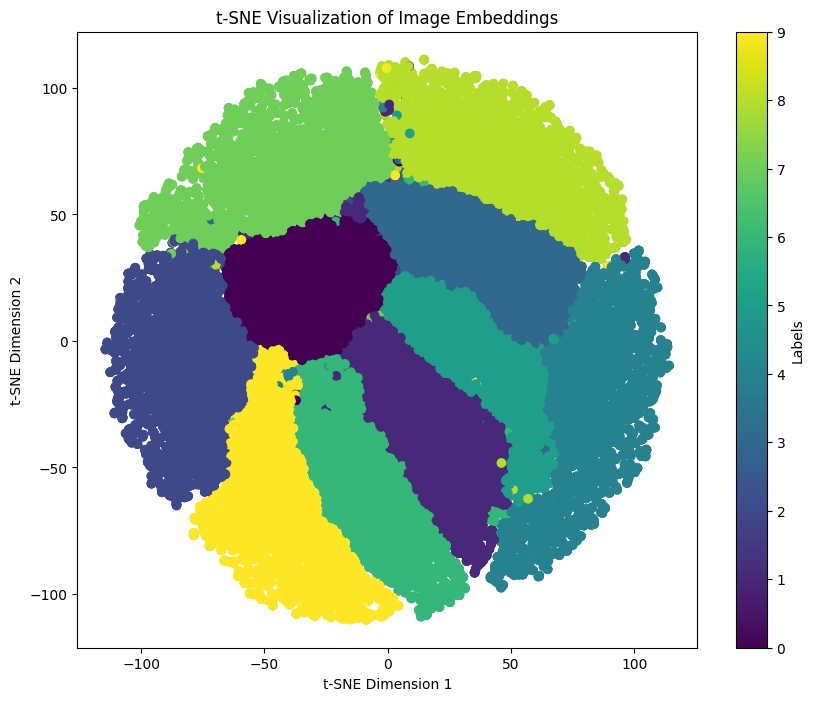

In [31]:
import matplotlib.pyplot as plt

# Visualize embeddings
plt.figure(figsize=(10, 8))
plt.scatter(X_embedded_image[:, 0], X_embedded_image[:, 1], c=labels, cmap='viridis')
plt.colorbar(label='Labels')
plt.title('t-SNE Visualization of Image Embeddings')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.show()


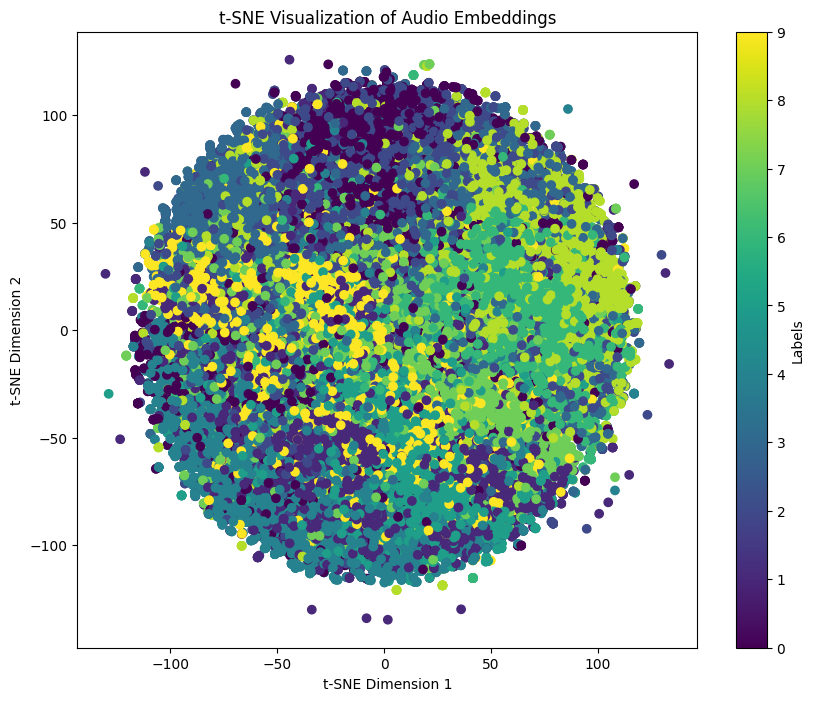

In [32]:
import matplotlib.pyplot as plt

# Visualize embeddings
plt.figure(figsize=(10, 8))
plt.scatter(X_embedded_audio[:, 0], X_embedded_audio[:, 1], c=labels, cmap='viridis')
plt.colorbar(label='Labels')
plt.title('t-SNE Visualization of Audio Embeddings')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.show()

K means

In [92]:
from sklearn.cluster import KMeans

# Define the number of clusters
num_clusters_image = 10
num_clusters_audio = 10

# Perform K-means clustering on image features
kmeans_image = KMeans(n_clusters=num_clusters_image)
image_clusters = kmeans_image.fit_predict(X_embedded_image)

# Perform K-means clustering on audio features
kmeans_audio = KMeans(n_clusters=num_clusters_audio)
audio_clusters = kmeans_audio.fit_predict(X_embedded_audio)


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


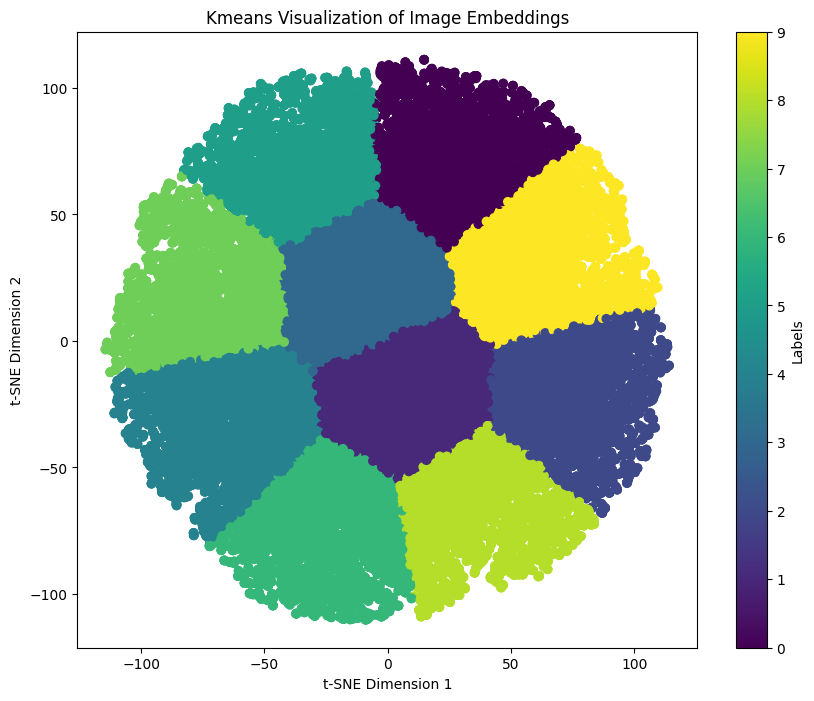

In [96]:
import matplotlib.pyplot as plt

# Visualize embeddings
plt.figure(figsize=(10, 8))
plt.scatter(X_embedded_image[:, 0], X_embedded_image[:, 1], c=image_clusters, cmap='viridis')
plt.colorbar(label='Labels')
plt.title('Kmeans Visualization of Image Embeddings')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.show()

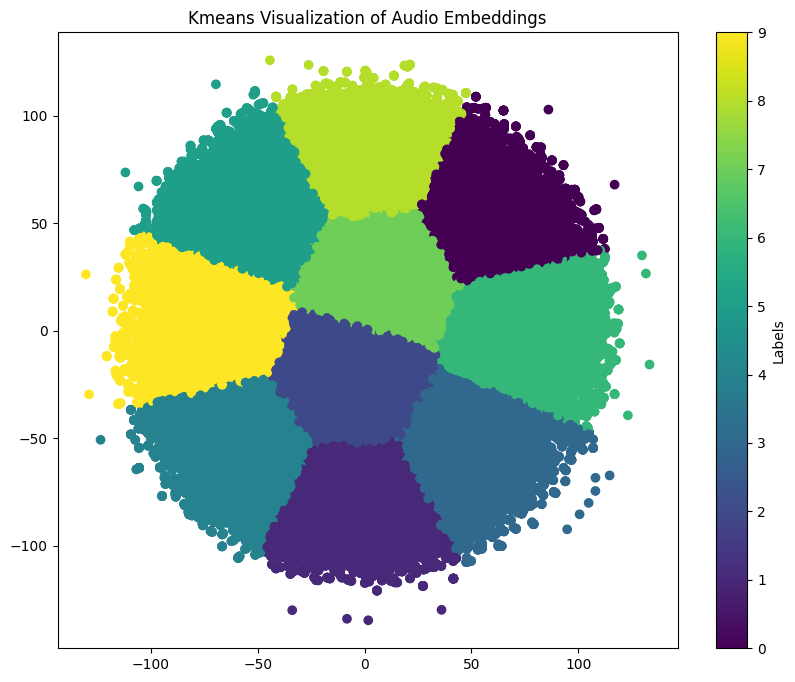

In [97]:
import matplotlib.pyplot as plt

# Visualize embeddings
plt.figure(figsize=(10, 8))
plt.scatter(X_embedded_audio[:, 0], X_embedded_audio[:, 1], c=audio_clusters, cmap='viridis')
plt.colorbar(label='Labels')
plt.title('Kmeans Visualization of Audio Embeddings')
plt.show()

The Kmeans model was able to cluster according to the labels. There is very less within cluster distance. However, the clusters are packed together so the boundary predictions would be off if embeddings are similar.